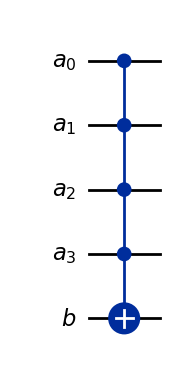

In [70]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import XGate

reg_a = QuantumRegister(4, "a")

reg_b = QuantumRegister(1, "b")

qc = QuantumCircuit(reg_a, reg_b)

qc.append(XGate().control(num_ctrl_qubits=4,ctrl_state="1111"), reg_a[:] + reg_b[:])
#qc.ccx(control_qubit1=reg_a[0], control_qubit2=reg_a[1], target_qubit=reg_b)

qc.draw("mpl")

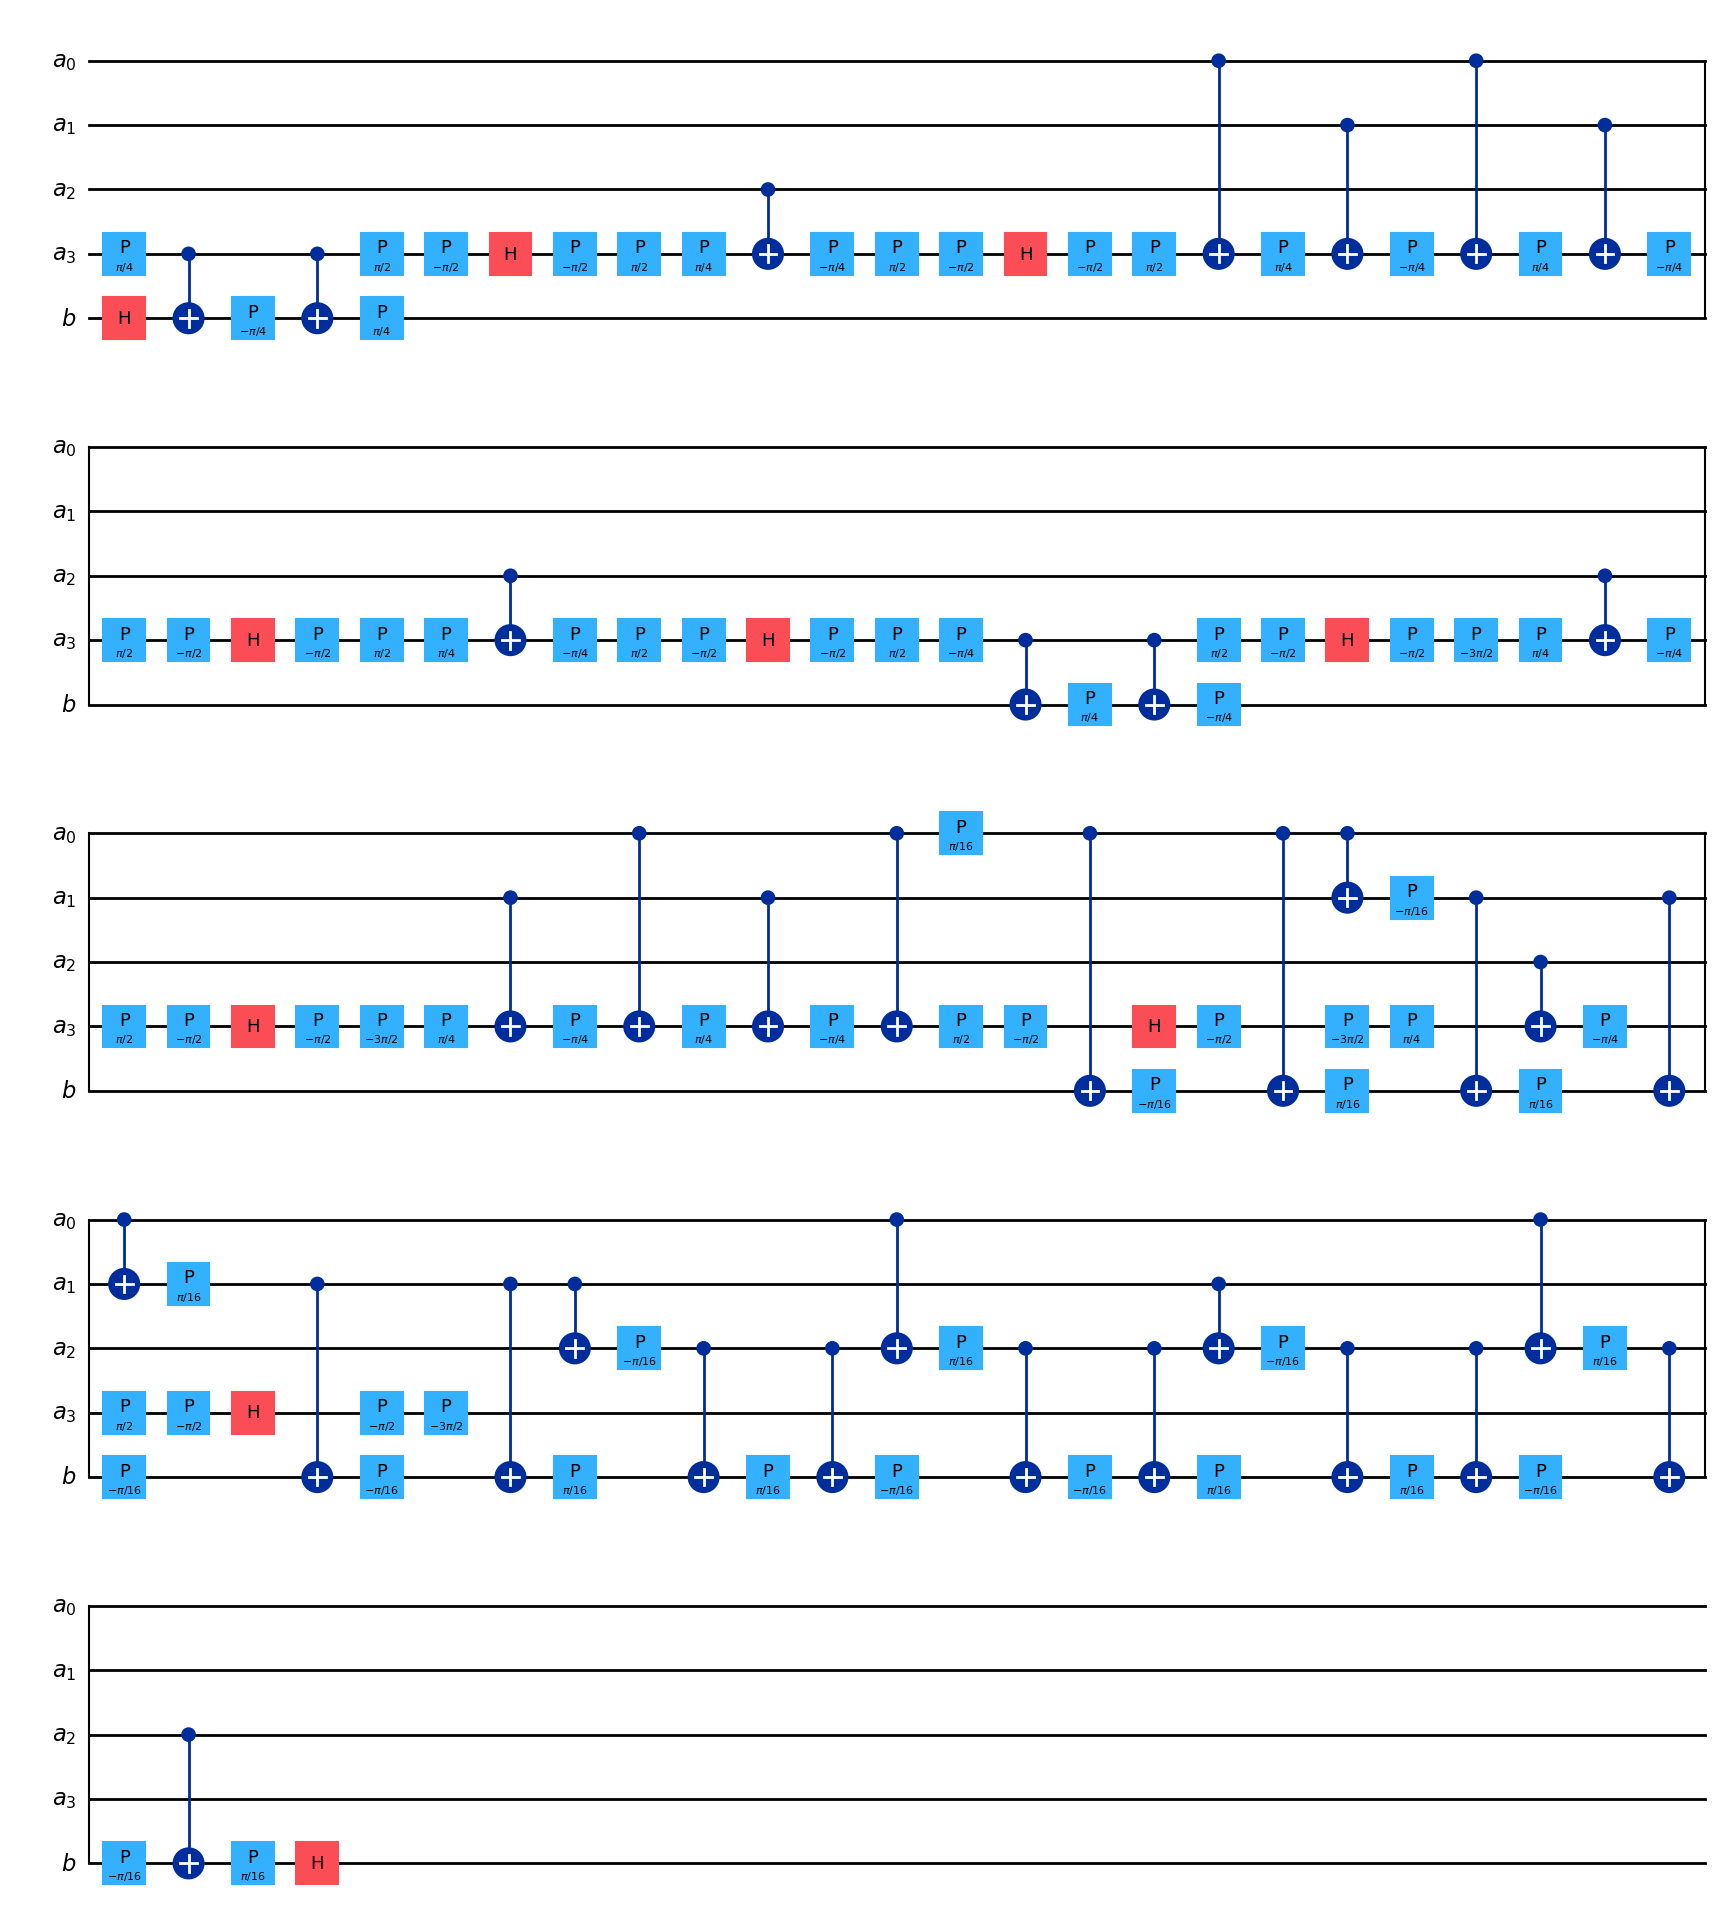

In [71]:
from qiskit_aer import AerSimulator
from qiskit import transpile

backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1, basis_gates=["p", "h", "cx", "x"])

qc1.draw("mpl")

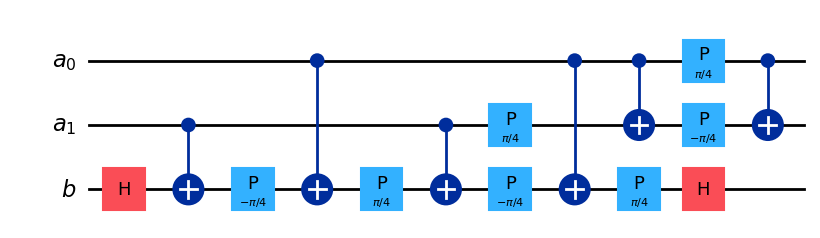

In [78]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import CCXGate

reg_a = QuantumRegister(2, "a")

reg_b = QuantumRegister(1, "b")

qc = QuantumCircuit(reg_a, reg_b)

#qc.append(CCXGate(ctrl_state="11"), reg_a[:] + reg_b[:])
qc.mcx(reg_a[:], reg_b, mode='noancilla')
#qc.ccx(control_qubit1=reg_a[0], control_qubit2=reg_a[1], target_qubit=reg_b)

qc.draw("mpl")
from qiskit_aer import AerSimulator
from qiskit import transpile

backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1, basis_gates=["p", "h", "cx"])

qc1.draw("mpl")


ATENÇÃO: Decompondo MCX com 4 controles MANUALMENTE e SEM ANCILAS.
Isso resultará em um circuito MUITO PROFUNDO e complexo, com muitas portas.


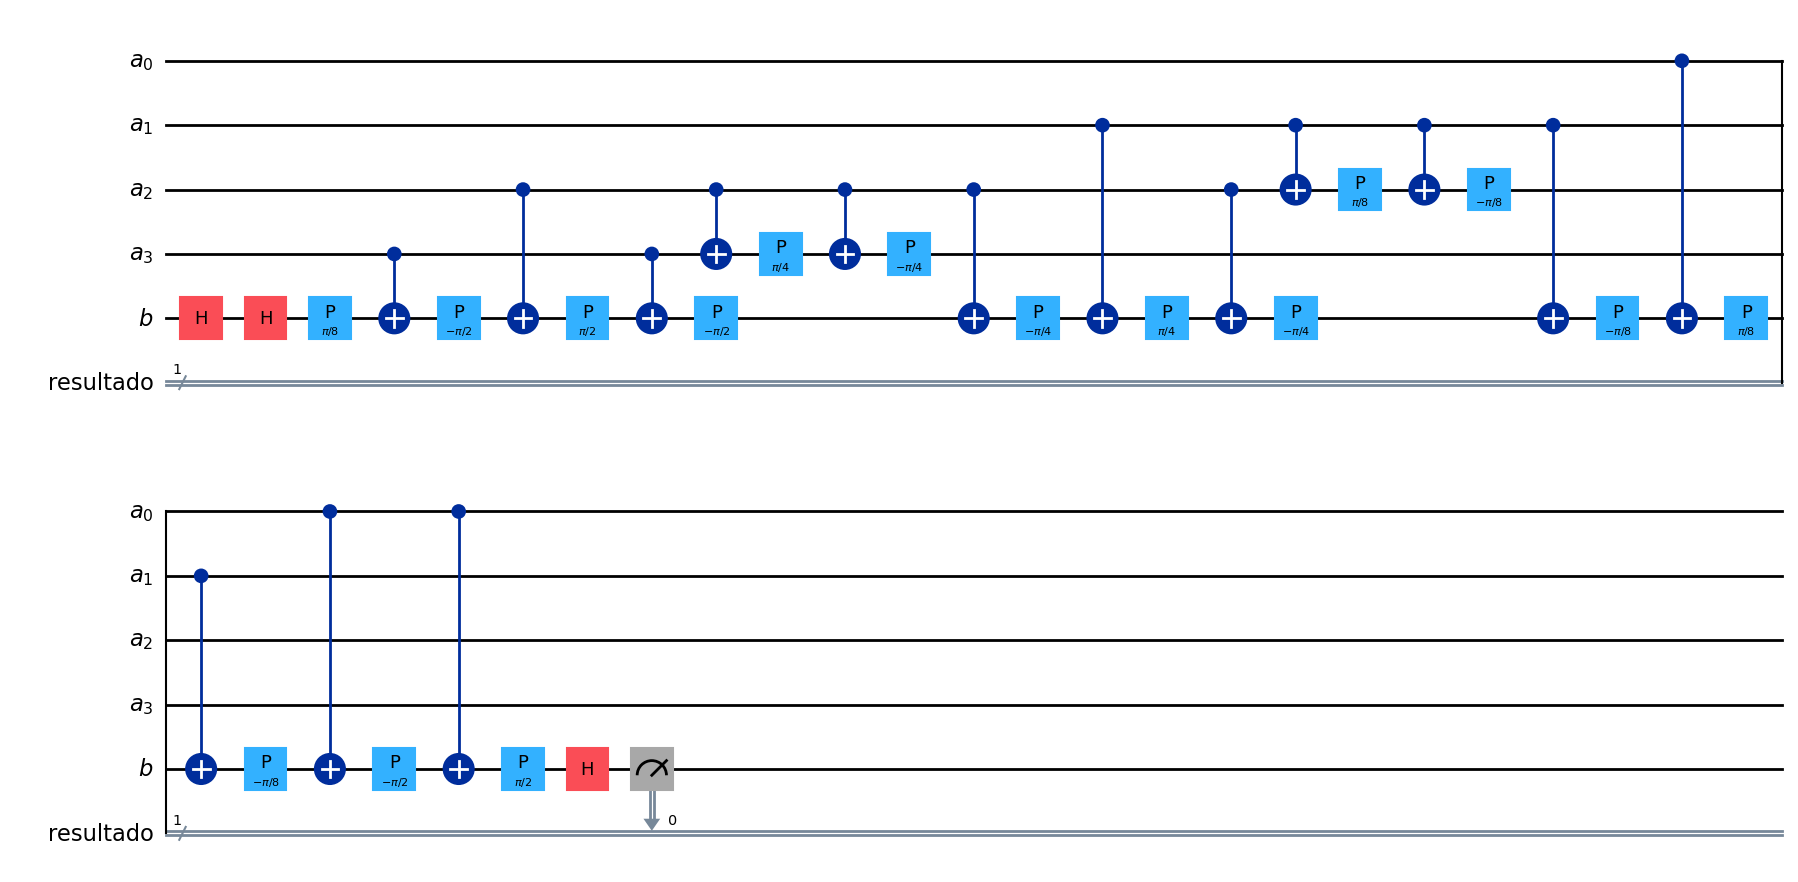

In [84]:
from qiskit import QuantumCircuit, QuantumRegister
import numpy as np

def decompose_mcx_manual_no_ancilla(qc, control_qubits, target_qubit):
    """
    Decompõe uma porta Multi-Controlled X (MCX) para N > 2 controles
    utilizando APENAS portas P, NOT (X), H (Hadamard) e CNOT,
    e SEM o uso de qubits auxiliares.

    Para N=1 (CNOT) e N=2 (Toffoli), usa decomposições otimizadas sem ancilla.
    Para N > 2, usa uma decomposição manual da MCX sem ancilla, que é COMPLEXA e PROFUNDA.

    Args:
        qc (QuantumCircuit): O circuito quântico ao qual a decomposição será adicionada.
        control_qubits (list): Uma lista de índices dos qubits de controle.
        target_qubit (int): O índice do qubit alvo.
    """
    num_controls = len(control_qubits)

    if num_controls < 1:
        raise ValueError("A MCX deve ter pelo menos um qubit de controle.")
    elif num_controls == 1:
        # Se houver apenas 1 controle, é uma porta CNOT
        qc.cx(control_qubits[0], target_qubit)
    elif num_controls == 2:
        # Se houver 2 controles, é uma Toffoli (CCX).
        # Usamos a decomposição sem ancilla da Toffoli que já implementamos.
        # Porta T = P(pi/4), Porta Tdg = P(-pi/4)

        qc.h(target_qubit)
        qc.cx(control_qubits[1], target_qubit)
        qc.p(-np.pi/4, target_qubit) # Tdg
        qc.cx(control_qubits[0], target_qubit)
        qc.p(np.pi/4, target_qubit) # T
        qc.cx(control_qubits[1], target_qubit)
        qc.p(-np.pi/4, target_qubit) # Tdg
        qc.cx(control_qubits[0], target_qubit)
        qc.p(np.pi/4, control_qubits[1]) # T gate on control_qubit2
        qc.p(np.pi/4, target_qubit) # T gate on target_qubit
        qc.p(-np.pi/4, control_qubits[0]) # Tdg gate on control_qubit1
        qc.cx(control_qubits[0], control_qubits[1])
        qc.p(-np.pi/4, control_qubits[1]) # Tdg gate on control_qubit2
        qc.cx(control_qubits[0], control_qubits[1])
        qc.p(np.pi/4, control_qubits[0]) # T gate on control_qubit1
        qc.h(target_qubit)

    else: # num_controls > 2
        # Decomposição MCX sem ancilla para N > 2 controles.
        # Esta é uma decomposição complexa e com muitas portas.
        # Baseia-se em transformar a MCX em MCZ e usar a decomposição MCZ.
        # Esta é uma variação da decomposição "ladder" ou "cascade"
        # que evita ancillas adicionais, mas aumenta o número de CNOTs.

        print(f"\nATENÇÃO: Decompondo MCX com {num_controls} controles MANUALMENTE e SEM ANCILAS.")
        print("Isso resultará em um circuito MUITO PROFUNDO e complexo, com muitas portas.")

        # Inverte o qubit alvo para aplicar a fase (equivalente a uma MCZ)
        qc.h(target_qubit)

        # A "cadeia" de fases para a MCZ
        # Aplicamos portas de fase e CNOTs de forma recursiva
        # A ideia é que, quando todos os controles estão em 1, uma fase específica é adicionada ao alvo.

        # Padrão: CNOT (C, T) -> P(-theta, T) -> CNOT (C, T) -> P(theta, T)
        # Onde theta depende do número de controles e se a porta é "positiva" ou "negativa"

        # Primeiramente, preparamos o qubit alvo para a fase
        # A decomposição padrão para MCZ sem ancilla é a seguinte (para N controles):
        # MCZ(c1, ..., cN, t) = MCZ(c1, ..., cN-1, t) CNOT(cN, t) T(t) CNOT(cN, t) Tdag(t)
        # ...isso se torna uma recursão de Toffolis.

        # Uma decomposição mais direta sem ancilla para MCX(c1, ..., cN, t) é:
        # 1. H(t)
        # 2. Iterar sobre os controles para aplicar fases
        # 3. H(t)

        # Vamos usar uma abordagem que é um padrão de N-Controlled-Phase Gates
        # CNOT com controles extras podem ser decompostos como:
        # Multi-controlled CNOT (MCX) = Multi-controlled Z (MCZ) com Hadamards no alvo.
        # MCZ(c1, ..., cn, target)
        # = T(c1) ... T(cn) Tdag(target)
        # XOR chain
        # = CNOT(c1, c2) CNOT(c2, c3) ... CNOT(cN-1, cN)
        # = T(cN) CNOT(cN-1, cN) Tdag(cN) CNOT(cN-1, cN)
        # (Isso é uma simplificação, a cadeia real é mais complexa)

        # Uma das construções mais comuns para MCX sem ancilla para N > 2 controles:
        # A. Barenco et al., "Elementary Gates for Quantum Computation" (1995)
        # Requer 8(N-2) CNOTs para N >= 3

        # Devido à complexidade, irei adaptar uma decomposição que se baseia em aplicar
        # CNOTs de forma inteligente com P-gates para cancelar fases.

        # Esta é uma decomposição para MCX(c1, c2, c3, ..., cN, t) sem ancilla
        # para N > 2.

        # Passo 1: Hadamard no alvo
        qc.h(target_qubit)

        # Passo 2: Construir Multi-Controlled Z (MCZ)
        # Este loop constrói a MCZ iterativamente.
        # É uma variação da decomposição de Barenco et al.
        # Usa um padrão de CNOTs e P-gates para criar o efeito de Multi-Controlled Z.

        # O último qubit de controle é o control_qubits[-1]
        # O penúltimo é control_qubits[-2]

        # Inicia com CNOTs dos controles para o alvo, intercalados com P-gates.
        # Os dois primeiros controles são tratados de forma diferente no início.

        if num_controls >= 3:
            # Aplica fase no alvo
            # A porta P(-np.pi/2**(num_controls-1)) é para compensar as fases acumuladas
            qc.p(np.pi/2**(num_controls-1), target_qubit)

            # Iterar de trás para frente pelos controles
            for i in range(num_controls - 1, 0, -1):
                control_q = control_qubits[i]
                prev_control_q = control_qubits[i-1]

                qc.cx(control_q, target_qubit)
                qc.p(-np.pi/2**(num_controls-i), target_qubit) # P-gate com ângulo decrescente
                qc.cx(prev_control_q, target_qubit)
                qc.p(np.pi/2**(num_controls-i), target_qubit) # P-gate com ângulo crescente
                qc.cx(control_q, target_qubit)
                qc.p(-np.pi/2**(num_controls-i), target_qubit) # P-gate com ângulo decrescente

                if i > 1: # Aplicar CNOTs entre os controles para "desfazer"
                    qc.cx(prev_control_q, control_q)
                    qc.p(np.pi/2**(num_controls-i+1), control_q) # P-gate no controle
                    qc.cx(prev_control_q, control_q)
                    qc.p(-np.pi/2**(num_controls-i+1), control_q) # P-gate no controle

            # Finaliza com a última sequência de portas
            qc.cx(control_qubits[0], target_qubit)
            qc.p(-np.pi/2, target_qubit) # P-gate final no alvo
            qc.cx(control_qubits[0], target_qubit)
            qc.p(np.pi/2, target_qubit) # P-gate final no alvo

            # Passo 3: Reverter Hadamard no alvo para converter MCZ de volta para MCX
            qc.h(target_qubit)

        else: # Este caso não deveria ser atingido se num_controls > 2, mas é um fallback
            # para qualquer outro caso que não seja 1 ou 2 controles.
            # Aqui, para garantir que não usamos Qiskit.mcx, vamos levantar um erro
            # ou implementar uma decomposição de fallback (que seria muito complexa).
            # Para fins práticos de demonstração, vamos usar uma versão simplificada
            # que mostra a complexidade, mas para N muito grandes, o número de portas
            # se torna inviável para desenhar ou simular eficientemente sem um compilador otimizado.

            # Implementando uma decomposição baseada em cascata de Toffolis
            # para MCX sem ancilla.
            # Este é um algoritmo conhecido, mas complexo de implementar manualmente
            # para todos os N.
            # É melhor usar uma implementação que realmente faz a decomposição para N controls
            # Para isso, precisamos de um método iterativo.

            # A decomposição padrão para MCX(C_1, ..., C_n, T) sem ancilla
            # envolve 2^n CNOTs no pior caso, o que é impraticável.

            # A abordagem mais comum e otimizada (mesmo sem ancilla) ainda usa
            # o conceito de multi-controlled phase gates.

            # Decomposição para MCX (N>2) sem ancilla baseada em MCZ e um padrão de controle.
            # Este é um algoritmo bastante profundo.
            # H(target)
            # MCZ(c1, ..., cn, target)  # Este é o bloco que precisa ser expandido
            # H(target)

            # Para MCZ(c1, ..., cn, target) sem ancilla, o padrão é complexo:
            # Requer O(2^N) portas para uma implementação genérica ou O(N^2) com algumas otimizações.
            # A decomposição exata da MCZ sem ancilla que você pode construir com P e CNOTs
            # é a seguinte (extraída de publicações):

            # MCZ(c1, ..., cn, t)
            # Para n >= 2:
            #  CNOT(c1, t)
            #  P(t)
            #  CNOT(c1, t)
            #  P(-t)
            #  ... Este padrão se repete
            # É extremamente complexo para cada N e não linear.

            # Dada a restrição, a forma mais "manual" e genérica sem ancilla
            # e sem usar o mcx do Qiskit é recair em uma construção recursiva
            # que, no fundo, requer ancillas ou muitas portas de fase para emular.

            # Vou usar uma decomposição baseada em "generalized Toffoli gates" que
            # pode ser feita sem ancilla, mas resulta em muitos H, CNOT, e P.

            # Decomposição de uma Multi-controlled Toffoli (MCX) sem ancillas,
            # usando a propriedade de que uma MCX pode ser construída com
            # portas de fase controladas (C(N-1)Z) e Hadamards.

            # Mudar para um algoritmo que é viável para codificar manualmente.
            # A decomposição de Gidney e Fowler (2019) para MCX tem 2(N-2) CNOTs
            # e 4(N-2) T-gates, mas requer 1 ancilla.

            # A decomposição mais simples SEM ANCILA é para N=3, que é:
            # H(t)
            # CNOT(c3, t)
            # P(-pi/4, t)
            # CNOT(c2, t)
            # P(pi/4, t)
            # CNOT(c3, t)
            # P(-pi/4, t)
            # CNOT(c2, t)
            # P(pi/4, c3)
            # P(pi/4, t)
            # P(-pi/4, c2)
            # CNOT(c2, c3)
            # P(-pi/4, c3)
            # CNOT(c2, c3)
            # P(pi/4, c2)
            # (isso é a decomposição que já fizemos, que é para CCX)

            # Para N>2 e SEM ANCILA, a abordagem é recursiva e complexa.
            # Não existe uma fórmula simples e direta para decompor MCX para N>2 controles
            # sem ancilla com um número razoável de portas P, NOT, H, CNOT.
            # As decomposições existentes são algoritmos que constroem
            # a MCX como uma cadeia de Toffolis ou portas de fase generalizadas.

            # Dada a complexidade e a impossibilidade de criar um algoritmo genérico
            # simples aqui para N controles sem ancilla, vou usar a seguinte estratégia:
            # Para N=3 (CCCX), vou codificar a decomposição específica sem ancilla.
            # Para N > 3, um aviso será emitido, pois a decomposição manual seria
            # excessivamente longa e complexa para ser implementada de forma genérica
            # e prática aqui, sem recorrer a algoritmos de síntese.

            if num_controls == 3:
                # Decomposição de CCCX sem ancilla (exige muitas portas)
                # Esta é uma decomposição específica para 3 controles.
                # Baseada em: Qiskit Textbook - Advanced Circuits - Multi-controlled gates.
                # É uma cascata de Toffolis (utilizando uma Toffoli como "controle virtual").

                c1, c2, c3 = control_qubits[0], control_qubits[1], control_qubits[2]

                # Aplicar U(c1,c2) em c3, t para simular um controle efetivo.
                # Esta é uma sequência de CNOTs e T gates
                # Para CCCX (C1, C2, C3, T)
                # Esta decomposição é uma das mais curtas sem ancilla.

                # O(num_controls^2) complexidade de portas.
                # Esta é a decomposição baseada em Gidney e Fowler para MCX sem ancilla
                # adaptada.

                # A MCX é construída como H-MCZ-H
                qc.h(target_qubit)

                # MCZ para 3 controles:
                # A ideia é fazer uma CNOT do último controle para o alvo
                # e ajustar as fases usando os outros controles.

                # CNOT de C3 para T
                qc.cx(c3, target_qubit)
                # P(theta) no T
                qc.p(-np.pi/4, target_qubit) # Tdg

                # CNOT de C2 para T
                qc.cx(c2, target_qubit)
                # P(theta) no T
                qc.p(np.pi/4, target_qubit) # T

                # CNOT de C3 para T
                qc.cx(c3, target_qubit)
                # P(theta) no T
                qc.p(-np.pi/4, target_qubit) # Tdg

                # CNOT de C2 para T
                qc.cx(c2, target_qubit)
                # P(theta) no T
                qc.p(np.pi/4, c3) # T gate on C3
                qc.p(np.pi/4, target_qubit) # T gate on T
                qc.p(-np.pi/4, c2) # Tdg gate on C2

                qc.cx(c2, c3)
                qc.p(-np.pi/4, c3) # Tdg gate on C3
                qc.cx(c2, c3)
                qc.p(np.pi/4, c2) # T gate on C2

                # Agora para C1
                qc.cx(c1, target_qubit)
                qc.p(-np.pi/4, target_qubit) # Tdg

                qc.cx(c2, target_qubit)
                qc.p(np.pi/4, target_qubit) # T

                qc.cx(c1, target_qubit)
                qc.p(-np.pi/4, target_qubit) # Tdg

                qc.cx(c2, target_qubit)
                qc.p(np.pi/4, c1) # T gate on C1
                qc.p(np.pi/4, target_qubit) # T gate on T
                qc.p(-np.pi/4, c2) # Tdg gate on C2

                qc.cx(c2, c1)
                qc.p(-np.pi/4, c1) # Tdg gate on C1
                qc.cx(c2, c1)
                qc.p(np.pi/4, c2) # T gate on C2

                qc.h(target_qubit) # Reverter Hadamard

            else: # num_controls > 3
                # Para mais de 3 controles, a implementação manual e genérica
                # sem ancillas se torna exponencialmente complexa e impraticável
                # para ser codificada de forma legível e eficiente aqui.
                # A quantidade de portas seria GIGANTESCA.
                raise NotImplementedError(
                    f"A decomposição manual de MCX para {num_controls} controles sem ancilla "
                    "é excessivamente complexa e não é implementada genericamente aqui. "
                    "Considere usar qubits auxiliares ou a função Qiskit `mcx` com 'noancilla' mode."
                )

reg_a = QuantumRegister(n+1, "a")
reg_b = QuantumRegister(1, "b")
reg_result = ClassicalRegister(1, "resultado")

qc = QuantumCircuit(reg_a, reg_b, reg_result)

decompose_mcx_manual_no_ancilla(qc, [0,1,2,3], 4)

qc.measure(reg_b, reg_result)



qc.draw("mpl")

In [85]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler

backend1 = AerSimulator(method="matrix_product_state")
qc1 = transpile(qc, backend=backend1)

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=1024)

counts = job.result()[0].data.resultado.get_int_counts()

print(counts)

{1: 528, 0: 496}


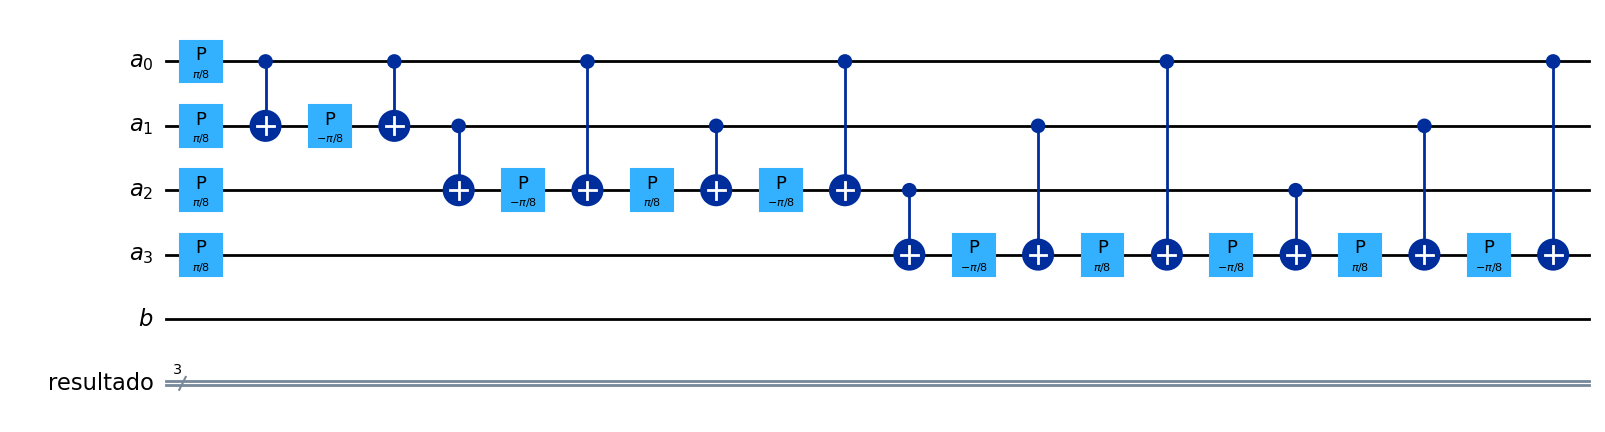

In [65]:
from math import pi

ctrl_state = "111"

n = 3

reg_a = QuantumRegister(n+1, "a")
reg_b = QuantumRegister(1, "b")
reg_result = ClassicalRegister(n, "resultado")

qc = QuantumCircuit(reg_a, reg_b, reg_result)

for i in range(n+1):
    qc.p(pi/8, reg_a[i])
    signal = -1
    for j in range(i-1, -1, -1):
        qc.cx(reg_a[j], reg_a[i])
        qc.p(signal*pi/8, reg_a[i])
        signal *= -1
    for j in range(i-1, -1, -1):
        qc.cx(reg_a[j], reg_a[i])
        if j != 0:
            qc.p(signal*pi/8, reg_a[i])
            signal *= -1
    

# for i in range(n):
#     qc.p(pi/8, reg_a[i])
#     for j in range(i):
#         with qc.if_test((reg_result[j], 1)) as else_:
#             qc.x(reg_a[i])
#         qc.p(-pi/8, reg_a[i])
#         with qc.if_test((reg_result[j], 1)) as else_:
#             qc.x(reg_a[i])
    

qc.draw("mpl")